In [128]:
# read variables iwc,zKu, iwc_label and zw_label from file cloudSat_thr01.nc
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
with nc.Dataset('cloudSat_thr01.nc','r') as f:
    iwc=f.variables['iwc'][:]
    zW=f.variables['zKu'][:]
    iwc_label=f.variables['iwc_label'][:]
    zw_label=f.variables['zw_label'][:]
    print(iwc.shape)



(138606, 50)


In [129]:
import pickle
from kazrRet import *
d=pickle.load(open('iwcCoeff.pkl','rb'))
iwcCoeff=d['iwcCoeff']
peak=d['peak']
iwcCoeff_SSRG=np.polyfit(zST[2,:],np.log10(iwcST[2,:]),1)
print(iwcCoeff_SSRG)
#print(iwcCoeff)

[ 0.08061103 -1.50649553]


In [130]:
nC=36
iwc_CSL=np.zeros((nC),float)
iwc_CSLn=np.zeros((nC),float)
iwc_SSRGL=np.zeros((nC),float)
for i in range(nC):
    a=np.nonzero(iwc_label==i)
    s1=0
    s2=0
    s3=0
    for k in a[0]:
        zw1=zW[k,:]
        a1=np.nonzero(zw1>-22)
        iwc1_SSRG=10**(iwcCoeff_SSRG[0]*zw1[a1]+iwcCoeff_SSRG[1])
        iwc1_CS=10**(iwcCoeff[i,0]*zw1[a1]+iwcCoeff[i,1])
        s1+=np.sum(iwc1_SSRG)
        s2+=np.sum(iwc[k,a1])
        s3+=np.sum(iwc1_CS)
    #print(s3/s2)
    iwc_CSL[i]=s3
    iwc_CSLn[i]=s2
    iwc_SSRGL[i]=s1


In [131]:
print(iwc_CSLn.sum()/iwc_SSRGL.sum())
#plt.hist(iwc_CSLn/iwc_CSL)
#plt.figure()
#plt.scatter(-np.log10(iwc_SSRGL/iwc_CSLn)+np.log10(1.11),peak)
print(np.corrcoef(-np.log10(iwc_SSRGL/iwc_CSLn),peak))
dnCoeff=np.polyfit(peak,-np.log10(iwc_SSRGL/iwc_CSL)+np.log10(1.11),1)
print(dnCoeff)
dnCoeff=np.array([0.01381017, 0.54397871])
dnCoeff=np.array([0.01975583, 0.22])
dn1D=np.polyval(dnCoeff,range(50))
#print(10**(dn1D))
#print(iwcCoeff_SSRG)

3.331030095567131
[[1.        0.9573302]
 [0.9573302 1.       ]]
[0.01975583 0.22229753]


In [146]:
with nc.Dataset('kext_atm.nc','r') as f:
    kext_atm=f.variables['kext_atm'][:]
    kext_atm=np.array(kext_atm)

with nc.Dataset('profiles.nc','r') as f:
    qv=f.variables['qv'][:]
    press=f.variables['press'][:]
    temp=f.variables['temp'][:]
    tempm=f.variables['tempm'][:]
    pressf=f.variables['pressf'][:]
    rho=f.variables['rho'][:]

kextCoeffL=[np.polyfit(zST[k,:200],np.log10(kextST[k,:200]),1) for k in range(4)]

npart=4
undef=0.0
nrefl=2
ice_type=1
import lidarSim as lidar
def get_pnorm(nz,dr,temp1,pres1,presf1,qv1,iwc1,rho1,dm_ice):
    h1=dr/2+np.arange(nz)*dr
    h1f=np.arange(nz)*dr
    q_lsice1=iwc1/rho1*1e-3
    q_lsice=q_lsice1[np.newaxis,:]
    pres1=pres1[np.newaxis,:]
    presf1=presf1[np.newaxis,:]
    temp1=temp1[np.newaxis,:]
    q_lsliq=np.zeros((1,nz),float)
    ls_radice=dm_ice/2*1e-3
    ls_radice=ls_radice[np.newaxis,:]
    ls_radliq=np.zeros((1,nz),float)
    q_cvice=np.zeros((1,nz),float)
    cv_radice=np.zeros((1,nz),float)
    q_cvliq=np.zeros((1,nz),float)
    cv_radliq=np.zeros((1,nz),float)
    temp=temp1
    pres=pres1
    presf=presf1
    pmol,pnorm,pnorm_perp_tot,\
        tautot,betatot_liq,\
        betatot_ice,\
        betatot,refl, \
        zheight,\
        beta_mol, tau_mol,\
        alpha= lidar.lidar_simulator(npart,nrefl,undef,\
                                     pres1,presf1,\
                                     temp1,
                                     q_lsliq,q_lsice,\
                                     q_cvliq,\
                                     q_cvice,\
                                     ls_radliq,\
                                     ls_radice,\
                                     cv_radliq,cv_radice,\
                                     ice_type)
    return pmol,pnorm


In [149]:
import lidarSim as lidSim
fisot=2.7
umu=np.cos(np.deg2rad(53))
nt1,nz=qv.shape
height=np.arange(nz+1)*0.240
nt=zW.shape[0]
iwc_SSRG=np.zeros((nt,50),float)
dm_SSRG=np.zeros((nt,50),float)

#dn1D*=0
dmCoeff=np.polyfit(zST[2,:],np.log10(dmST[2,:]),1)
iwcLowCoeff=np.polyfit(zST[2,:200],np.log10(iwcST[2,:200]),1)
kextCoeffL=[np.polyfit(zST[k,:200],np.log10(kextST[k,:200]),1) for k in range(4)]
print(dmCoeff)
dn1Da=dn1D+1.75
tbL=[]
epsL=[]
zKu=np.zeros((nt,50),float)-99.9
zKuL=[]
pnormL=[]
for i in range(10+0*nt):
    zw1=zW[i,:]
    a1=np.nonzero(zw1>-22)
    kextI=np.zeros((50,4),float)
    salbI=np.zeros((50,4),float)
    asymI=np.zeros((50,4),float)
    ic=np.random.randint(0,30)
    kext1D=kext_atm[ic,:,:].copy()
    salb1D=np.zeros((64,4),float)
    asym1D=np.zeros((64,4),float)
    for k in a1[0]:
        ifind = lidSim.bisection2(zST[2,:],zw1[k]-10*(dn1Da[k]))
        iwc_SSRG[i,k]=iwcST[2,ifind]*10**(dn1Da[k])
        zKu[i,k]=zST[0,ifind]+10*(dn1Da[k])
        dm_SSRG[i,k]=10**(dmCoeff[0]*(zw1[k]-10*dn1Da[k])+dmCoeff[1]+dn1Da[k])
        if ifind==1:
            iwc_SSRG[i,k]=10**(iwcLowCoeff[0]*(zw1[k]-10*dn1Da[k])+iwcLowCoeff[1]+dn1Da[k])
            for ifreq in range(4):
                kextI[k,ifreq]=10**(kextCoeffL[ifreq][0]*(zw1[k]-10*dn1Da[k])+kextCoeffL[ifreq][1]+dn1Da[k])
                salbI[k,ifreq]=kextI[k,ifreq]*kscaST[ifreq+2,0]/kextST[ifreq+2,0]  
                asymI[k,ifreq]=gST[ifreq+2,0]
            zKu[i,k]=zw1[k]
        else:
            for ifreq in range(4):
                kextI[k,ifreq]=kextST[ifreq+2,ifind]*10**(dn1Da[k])
                salbI[k,ifreq]=kscaST[ifreq+2,ifind]
                asymI[k,ifreq]=gST[ifreq+2,ifind]
    nz=50
    dr=0.240
    temp1=temp[ic,14:64]
    pres1=press[ic,14:64]
    presf1=pressf[ic,14:65]
    qv1=qv[ic,14:64]
    iwc1=iwc_SSRG[i,:]
    rho1=pres1/(287.05*temp1)
    dm_ice=dm_SSRG[i,:]
    pmol,pnorm=get_pnorm(nz,dr,temp1,pres1,presf1,qv1,iwc1,rho1,dm_ice)
    
    kext1D[14:64,:]+=kextI[:,:]
    salb1D[14:64,:]=salbI[:,:]
    asym1D[14:64,:]=asymI[:,:]
    salb1D/=kext1D
    emis=0.8+np.random.random()*0.2
    ebar=emis
    tb1=[]
    for ik in range(4):
        tbout = lidSim.radtran(umu,temp[ic][0],temp[ic],height,kext1D[:,ik],salb1D[:,ik],asym1D[:,ik],fisot,emis,ebar)
        tb1.append(tbout)
        if tbout!=tbout:
            stop
    tbL.append(tb1)
    zKuL.append(zKu[i,:])
    epsL.append(emis)
    pnormL.append(pnorm[0,:])
import xarray as xr
ds=xr.Dataset({'tb':(['time','chan'],tbL),
                'zKu':(['time','height'],zKuL),
                'pnorm':(['time','height'],1e3*np.array(pnormL)),
                'iwc_SSRG':(['time','height'],iwc_SSRG),
                'eps':(['time'],epsL)},
                coords={'time':np.arange(len(tbL)),
                        'chan':np.arange(4),
                        'height':np.arange(50)})

#ds.to_netcdf('simObsInclined.nc',format='NETCDF4')
ds.to_netcdf('simObsInclined.nc',format='NETCDF4',encoding={'tb':{'zlib':True,'complevel':5},\
    'zKu':{'zlib':True,'complevel':5},'iwc_SSRG':{'zlib':True,'complevel':5},\
        'pnorm':{'zlib':True,'complevel':5},'eps':{'zlib':True,'complevel':5}})  



[ 0.0200911  -0.12390667]


ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['time', 'height'], array([[[2.44087551e-05, 2.39554192e-05, 2.35003918e-05, 2.30448513e-05,
         2.25837612e-05, 2.21201535e-05, 2.16550725e-05, 2.11896913e-05,
         2.07252342e-05, 2.02600586e-05, 1.98035686e-05, 1.93447977e-05,
         1.89026887e-05, 1.84574110e-05, 1.80290990e-05, 1.76023987e-05,
         1.71884221e-05, 1.67814796e-05, 1.63799195e-05, 1.59889896e-05,
         1.55987673e-05, 5.47707430e-04, 3.06702591e-03, 7.66449654e-03,
         1.28638381e-02, 1.38834193e-02, 1.98722463e-02, 2.48935763e-02,
         2.53614876e-02, 1.81837305e-02, 1.20809888e-02, 4.54717374e-04,
         4.43329161e-04, 4.31967666e-04, 4.20393102e-04, 4.08374530e-04,
         3.95931740e-04, 3.83261533e-04, 3.70552239e-04, 3.58513498e-04,
         3.47208668e-04, 3.36352736e-04, 3.25756060e-04, 3.14633915e-04,
         3.02967033e-04, 2.91075761e-04, 2.78959284e-04, 2.67402240e-04,
         2.56669591e-04, 2.46934505e-04]],

       [[1.95285145e-04, 1.91476094e-04, 1.87655125e-04, 1.83903845e-04,
         1.80145376e-04, 1.76417598e-04, 1.72685832e-04, 1.68956816e-04,
         1.65237550e-04, 1.61506934e-04, 1.57804301e-04, 1.54137801e-04,
         1.50534106e-04, 1.47012048e-04, 1.43552039e-04, 1.40233737e-04,
         1.36950373e-04, 1.33782291e-04, 1.30631961e-04, 1.27525927e-04,
         1.24437152e-04, 1.21368859e-04, 1.18380784e-04, 1.15401934e-04,
         1.12595924e-04, 5.55286556e-03, 1.70873292e-02, 2.29980964e-02,
         2.40828563e-02, 2.15410534e-02, 9.46385693e-03, 4.06290637e-04,
         3.95704876e-04, 3.85025633e-04, 3.74404772e-04, 1.16773108e-02,
         3.83055391e-04, 3.71305447e-04, 3.59809957e-04, 3.48603586e-04,
         3.37746023e-04, 3.27123184e-04, 3.16718040e-04, 3.05424270e-04,
         2.93218123e-04, 2.80410954e-04, 2.68099597e-04, 2.56668834e-04,
         2.46502721e-04, 2.37505708e-04]],

       [[1.74277418e-04, 1.70787389e-04, 1.67352657e-04, 1.63946897e-04,
         1.60567855e-04, 1.57218165e-04, 1.53881003e-04, 1.50591295e-04,
         1.47292172e-04, 1.44071280e-04, 1.40820295e-04, 1.37656796e-04,
         1.34467147e-04, 1.31359237e-04, 1.28263651e-04, 1.25228893e-04,
         1.22249883e-04, 1.19300086e-04, 1.16439318e-04, 1.13592461e-04,
         1.10837515e-04, 1.08117623e-04, 1.05458195e-04, 2.54464452e-03,
         8.20071530e-03, 2.17165425e-02, 3.51574682e-02, 3.25876772e-02,
         1.46722933e-02, 4.64846758e-04, 4.53542656e-04, 4.42483084e-04,
         4.31487628e-04, 4.20276978e-04, 4.08411404e-04, 3.95910378e-04,
         3.82956554e-04, 3.69806308e-04, 3.57208686e-04, 3.45691777e-04,
         3.35057179e-04, 3.24754539e-04, 3.13827652e-04, 3.01539665e-04,
         2.88927724e-04, 2.76392471e-04, 2.64700153e-04, 2.54023151e-04,
         2.44438415e-04, 2.35481886e-04]],

       [[6.25956600e-05, 6.13369266e-05, 6.00991698e-05, 5.88718176e-05,
         5.76530510e-05, 5.64505863e-05, 5.52523888e-05, 5.40799083e-05,
         5.29061108e-05, 5.17683620e-05, 5.06223259e-05, 4.95064414e-05,
         4.83805125e-05, 4.72744759e-05, 4.61686577e-05, 4.50742045e-05,
         4.39941177e-05, 4.29178544e-05, 4.18723903e-05, 4.08364613e-05,
         3.98351694e-05, 1.10247533e-03, 4.39134892e-03, 7.84617756e-03,
         1.08524039e-02, 1.64744891e-02, 2.62801107e-02, 3.04992162e-02,
         2.27951836e-02, 4.26095590e-04, 4.15799528e-04, 4.05726925e-04,
         3.95608338e-04, 3.85027262e-04, 3.73794202e-04, 3.61914834e-04,
         3.49870563e-04, 3.37801961e-04, 3.26296431e-04, 3.15793644e-04,
         3.06100497e-04, 2.96396727e-04, 1.23102488e-02, 2.99893611e-04,
         2.87859351e-04, 2.76179722e-04, 2.65199080e-04, 2.55034596e-04,
         2.45765987e-04, 2.37013737e-04]],

       [[4.95400400e-06, 4.85474493e-06, 4.75661454e-06, 4.65897210e-06,
         4.56197722e-06, 4.46665035e-06, 4.37230210e-06, 4.27971099e-06,
         4.18719173e-06, 4.09638142e-06, 4.00455610e-06, 3.91544381e-06,
         3.82538519e-06, 3.73734565e-06, 3.64884500e-06, 3.56138730e-06,
         3.47543778e-06, 3.39119151e-06, 3.30993657e-06, 3.22894766e-06,
         3.15056923e-06, 1.32341855e-04, 3.93500581e-04, 6.91286288e-04,
         2.12759408e-03, 6.93588285e-03, 2.01558545e-02, 4.30379249e-02,
         4.29723933e-02, 2.44103968e-02, 4.53820132e-04, 4.42710123e-04,
         4.31602821e-04, 4.20043361e-04, 4.08122083e-04, 3.96046205e-04,
         3.83551494e-04, 3.70541995e-04, 3.57322890e-04, 3.44939239e-04,
         3.33680713e-04, 3.23327520e-04, 3.12992954e-04, 3.01741879e-04,
         2.90009746e-04, 2.77740182e-04, 2.66012212e-04, 2.55085120e-04,
         2.45076779e-04, 2.35704385e-04]],

       [[3.25528831e-08, 3.19006510e-08, 3.12558335e-08, 3.06142418e-08,
         2.99768814e-08, 2.93509448e-08, 2.87309732e-08, 2.81220718e-08,
         2.75141492e-08, 2.69174247e-08, 2.63140585e-08, 2.57284540e-08,
         2.51367069e-08, 2.45582132e-08, 2.39766447e-08, 2.34019470e-08,
         2.28371917e-08, 2.22836185e-08, 2.17496723e-08, 2.12174953e-08,
         4.06458042e-07, 1.86630177e-06, 6.27632335e-06, 1.71691881e-05,
         1.11517940e-04, 1.14487519e-03, 9.27899592e-03, 3.24776024e-02,
         6.03751652e-02, 3.80079895e-02, 4.53820132e-04, 4.42710123e-04,
         4.31602821e-04, 4.20043361e-04, 4.08122083e-04, 3.96046205e-04,
         3.83551494e-04, 3.70541995e-04, 3.57322890e-04, 3.44939239e-04,
         3.33680713e-04, 3.23327520e-04, 3.12992954e-04, 3.01741879e-04,
         2.90009746e-04, 2.77740182e-04, 2.66012212e-04, 2.55085120e-04,
         2.45076779e-04, 2.35704385e-04]],

       [[1.91773125e-10, 1.88213764e-10, 1.84638915e-10, 1.81059612e-10,
         1.77436954e-10, 1.73794576e-10, 1.70140416e-10, 1.66484021e-10,
         1.62834787e-10, 1.59180058e-10, 1.55593372e-10, 1.51989032e-10,
         1.48515394e-10, 1.45016874e-10, 1.41651704e-10, 1.38299303e-10,
         1.35046613e-10, 1.31849531e-10, 1.28694416e-10, 1.25622873e-10,
         9.11988707e-09, 5.29713944e-08, 1.96548484e-07, 1.30736839e-06,
         1.72839045e-05, 3.39338789e-04, 6.03670487e-03, 3.81570533e-02,
         6.60249889e-02, 3.08536366e-02, 4.66117839e-04, 4.54717374e-04,
         4.43329161e-04, 4.31967666e-04, 4.20393102e-04, 4.08374530e-04,
         3.95931740e-04, 3.83261533e-04, 3.70552239e-04, 3.58513498e-04,
         3.47208668e-04, 3.36352736e-04, 3.25756060e-04, 3.14633915e-04,
         3.02967033e-04, 2.91075761e-04, 2.78959284e-04, 2.67402240e-04,
         2.56669591e-04, 2.46934505e-04]],

       [[6.39454378e-10, 6.26642183e-10, 6.13975648e-10, 6.01372507e-10,
         5.88852411e-10, 5.76556858e-10, 5.64378433e-10, 5.52417445e-10,
         5.40475720e-10, 5.28753930e-10, 5.16901633e-10, 5.05398334e-10,
         4.93774355e-10, 4.82410556e-10, 4.70986528e-10, 4.59697447e-10,
         4.48603654e-10, 4.37729464e-10, 4.27240882e-10, 9.37511668e-09,
         1.11089498e-07, 7.27940346e-07, 4.79938308e-06, 6.54244795e-05,
         1.11771456e-03, 8.21906514e-03, 2.37763487e-02, 4.16704938e-02,
         4.29307148e-02, 2.37842146e-02, 4.53820132e-04, 4.42710123e-04,
         4.31602821e-04, 4.20043361e-04, 4.08122083e-04, 3.96046205e-04,
         3.83551494e-04, 3.70541995e-04, 3.57322890e-04, 3.44939239e-04,
         3.33680713e-04, 3.23327520e-04, 3.12992954e-04, 3.01741879e-04,
         2.90009746e-04, 2.77740182e-04, 2.66012212e-04, 2.55085120e-04,
         2.45076779e-04, 2.35704385e-04]],

       [[6.63817046e-09, 6.50553256e-09, 6.37550723e-09, 6.24624574e-09,
         6.11802120e-09, 5.99078875e-09, 5.86459281e-09, 5.73923309e-09,
         5.61458124e-09, 5.49119106e-09, 5.36815126e-09, 5.24763166e-09,
         5.12654230e-09, 5.00772268e-09, 4.88844609e-09, 4.77221418e-09,
         4.65753347e-09, 4.54562032e-09, 2.16482803e-07, 7.23577955e-07,
         3.44319483e-06, 3.54064250e-05, 6.39641657e-04, 7.12168496e-03,
         2.36594602e-02, 3.98332477e-02, 2.48729009e-02, 1.58658791e-02,
         1.85889564e-02, 1.10986289e-02, 4.54205321e-04, 4.43005905e-04,
         4.31944005e-04, 4.20346390e-04, 4.08463733e-04, 3.96282412e-04,
         3.83503822e-04, 3.70416121e-04, 3.57405719e-04, 3.45281645e-04,
         3.34261596e-04, 3.24211840e-04, 3.13972036e-04, 3.02970438e-04,
         2.91293341e-04, 2.79095402e-04, 2.67260504e-04, 2.56089581e-04,
         2.45656032e-04, 2.36036271e-04]],

       [[8.76367257e-10, 8.60101657e-10, 8.43765169e-10, 8.27408420e-10,
         8.10853495e-10, 7.94208532e-10, 7.77509723e-10, 7.60800700e-10,
         7.44124373e-10, 7.27423066e-10, 7.11032455e-10, 6.94561297e-10,
         6.78687606e-10, 6.62699895e-10, 6.47321696e-10, 6.32001840e-10,
         6.17137674e-10, 1.87192288e-08, 2.16421583e-07, 1.69307009e-06,
         1.94018303e-05, 4.31838998e-04, 6.52823085e-03, 2.06018612e-02,
         3.11526377e-02, 3.56200635e-02, 2.74323821e-02, 1.90766826e-02,
         4.89419443e-04, 4.77726135e-04, 4.66117839e-04, 4.54717374e-04,
         4.43329161e-04, 4.31967666e-04, 4.20393102e-04, 4.08374530e-04,
         3.95931740e-04, 3.83261533e-04, 3.70552239e-04, 3.58513498e-04,
         3.47208668e-04, 3.36352736e-04, 3.25756060e-04, 3.14633915e-04,
         3.02967033e-04, 2.91075761e-04, 2.78959284e-04, 2.67402240e-04,
         2.56669591e-04, 2.46934505e-04]]], dtype=float32)) to Variable.

In [148]:
print()

[[-8.8882723e-07 -8.7187260e-07 -8.5510158e-07 -8.3830616e-07
  -8.2154691e-07 -8.0460723e-07 -7.8761087e-07 -7.7033320e-07
  -7.5297424e-07 -7.3568606e-07 -7.1840805e-07 -7.0152811e-07
  -6.8465579e-07 -6.6855745e-07 -6.5263725e-07 -6.3728390e-07
  -6.2217634e-07 -6.0735977e-07 -5.9293109e-07 -5.7856511e-07
  -5.6471430e-07 -1.7505442e-08  2.5130771e-06  7.1254144e-06
   1.2356228e-05  1.3374103e-05  1.9406278e-05  2.4420022e-05
   2.4881394e-05  1.7734288e-05  1.1627107e-05  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]


In [150]:
print(np.array(pnormL).shape)
#print(tbL)
#write ds to a compressed netcdf file using encoding
#ds.to_netcdf('simObsInclined.nc',format='NETCDF4',encoding={'tb':{'zlib':True,'complevel':5},
#'zKu':{'zlib':True,'complevel':5},'eps':{'zlib':True,'complevel':5}})  




(10, 1, 50)


0.06873033762232066
0.078562036
[[1.         0.92743434]
 [0.92743434 1.        ]]


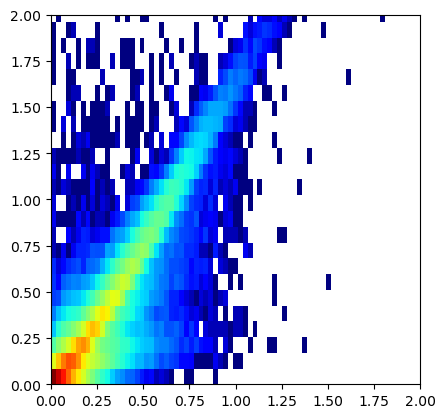

In [105]:
#print(dn1D)
a=np.nonzero(iwc_SSRG>0)
print(iwc_SSRG[a].mean())
print(iwc[a].mean())
print(np.corrcoef(iwc_SSRG[a],iwc[a]))
ax=plt.subplot(111)
iwc_hist2d=plt.hist2d(iwc_SSRG[a],iwc[a],bins=100,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.xlim(0,2)
plt.ylim(0,2)
ax.set_aspect('equal')